In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from datetime import date, datetime, timedelta

In [66]:
df = pd.read_csv('member_sample.csv', index_col = 0)

In [67]:
df.head()

,Individual Key,Household Key,Member Flag,City,State - Grouped,ZIP5,ZIP9,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,...,SC Vehicle Manufacturer Name,SC Vehicle Model Name,SVC Facility Name,SVC Facility Type,Total Cost,Tow Destination Latitude,Tow Destination Longitude,Tow Destination Name,Was Duplicated,Was Towed To AAR Referral
0,10000003.0,10462590.0,Y,NEW HAVEN,CT,6511.0,65111349.0,N,N,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52211550.0,4500791.0,Y,WEST WARWICK,RI,2893.0,28933850.0,N,Y,N,...,TOYOTA,CAMRY,ASTRO WRECKER SERVICE,independent repair,32.5,41.0,-71.0,Aar / Johnson's Auto Service,0.0,1.0
2,52211550.0,4500791.0,Y,WEST WARWICK,RI,2893.0,28933850.0,N,Y,N,...,TOYOTA,CAMRY,Astro Wrecker Service,independent repair,30.0,0.0,0.0,NaN,0.0,0.0
3,52211550.0,4500791.0,Y,WEST WARWICK,RI,2893.0,28933850.0,N,Y,N,...,TOYOTA,CAMRY,ASTRO WRECKER SERVICE,independent repair,32.5,0.0,0.0,NaN,0.0,0.0
4,52211550.0,4500791.0,Y,WEST WARWICK,RI,2893.0,28933850.0,N,Y,N,...,TOYOTA,CAMRY,ASTRO WRECKER SERVICE,independent repair,30.0,0.0,0.0,NaN,0.0,0.0


## Define Useful Functions

In [68]:
#Turn Y and N values to binary
def to_binary(x):
    if x == 'Y':
        return 1
    else:
        return 0

In [69]:
#Find columns that contains 'String' value
def print_cols(df, string):
    cols = [i for i in df.columns if string in i]
    return cols

In [70]:
#Map means to 1 or 0
def buy_or_not(x):
    if x > 0:
        return 1
    else:
        return 0

### EDA before building model

In [71]:
df.City.value_counts()[:30]

WARWICK             2815
CRANSTON            2742
PROVIDENCE          1690
NORTH PROVIDENCE     948
COVENTRY             778
JOHNSTON             703
EAST GREENWICH       641
PAWTUCKET            640
NORTH KINGSTOWN      637
WEST WARWICK         606
CUMBERLAND           560
NARRAGANSETT         531
WAKEFIELD            497
RIVERSIDE            436
LINCOLN              402
EAST PROVIDENCE      372
PORTSMOUTH           328
MANVILLE             322
NEWPORT              321
BARRINGTON           313
GREENVILLE           288
SMITHFIELD           284
BRISTOL              279
MIDDLETOWN           272
RUMFORD              268
WOONSOCKET           262
TIVERTON             253
NORTH SCITUATE       222
JAMESTOWN            218
NORTH SMITHFIELD     179
Name: City, dtype: int64

In [72]:
df['State - Grouped'].value_counts()

RI    20937
CT      407
Name: State - Grouped, dtype: int64

In [73]:
df.groupby('State - Grouped')['Total Cost'].mean()

State - Grouped
CT    40.034405
RI    47.361980
Name: Total Cost, dtype: float64

In [74]:
df.groupby('Education')['Total Cost'].mean()

Education
Completed College    48.140840
Graduated School     44.439583
High School          47.322308
Some College         47.318179
Unknown              48.125212
Name: Total Cost, dtype: float64

In [75]:
FSV_cols = print_cols(df, 'FSV')
FSV_cols

['FSV CMSI Flag',
 'FSV Credit Card Flag',
 'FSV Deposit Program Flag',
 'FSV Home Equity Flag',
 'FSV ID Theft Flag',
 'FSV Mortgage Flag']

In [76]:
df.groupby('State - Grouped')['FSV Mortgage Flag'].size()

State - Grouped
CT      407
RI    20937
Name: FSV Mortgage Flag, dtype: int64

#### Convert FSV columns to binary

In [77]:
for col in FSV_cols:
    df[col] = df[col].apply(to_binary)

In [78]:
df[FSV_cols].head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag
0,0,0,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [79]:
df.groupby('State - Grouped')['FSV Mortgage Flag'].mean()

State - Grouped
CT    0.00000
RI    0.00129
Name: FSV Mortgage Flag, dtype: float64

In [80]:
df.groupby('Children')['Number of Children'].describe()

,count,unique,top,freq
Children,,,,
No,5379,1,No children,5379
Yes,6631,7,One Child,3871


In [81]:
df['Number of Children'].value_counts()

No children       5482
One Child         3871
Two Children      1582
Three Children     750
Four Children      276
Five Children       45
Six Children         4
Name: Number of Children, dtype: int64

### Turn Children Counts into numerical columns

In [82]:
vals = df['Number of Children'].value_counts().index
nums = list(range(7))

In [83]:
df['Number of Children'] = df['Number of Children'].map({v:n for v,n in zip(vals,nums)})

In [84]:
df['Number of Children'].value_counts()

0.0    5482
1.0    3871
2.0    1582
3.0     750
4.0     276
5.0      45
6.0       4
Name: Number of Children, dtype: int64

#### Continue EDA

In [85]:
df['Credit Ranges'].value_counts()

750-799       4101
700-749       2542
650-699       1911
800+          1785
600-649        883
Unknown        414
550-599        197
500-549        165
499 & Less      12
Name: Credit Ranges, dtype: int64

In [86]:
#Trun Credit to Numeric
def credit_to_nums(x):
    if x == 'Unknown':
        return 550
    else:
        value = x[:3]
        return int(value)
    

In [87]:
test = df['Credit Ranges'][:15]
test

0         NaN
1     600-649
2     600-649
3     600-649
4     600-649
5     600-649
6     600-649
7     600-649
8     600-649
9     600-649
10        NaN
11    750-799
12    750-799
13    750-799
14    750-799
Name: Credit Ranges, dtype: object

In [88]:
df['Credit Ranges'].fillna('650-599', inplace = True)

In [89]:
df['Credit Ranges'].value_counts()

650-599       9334
750-799       4101
700-749       2542
650-699       1911
800+          1785
600-649        883
Unknown        414
550-599        197
500-549        165
499 & Less      12
Name: Credit Ranges, dtype: int64

In [90]:
df['Credit Ranges'] = df['Credit Ranges'].apply(credit_to_nums)

In [91]:
df['Credit Ranges'].value_counts()

650    11245
750     4101
700     2542
800     1785
600      883
550      611
500      165
499       12
Name: Credit Ranges, dtype: int64

In [92]:
df.shape

(21344, 112)

In [93]:
df_exp = pd.get_dummies(df, columns = ['kcl_B_IND_MosaicsGrouping'])

In [94]:
kcl_cols = print_cols(df_exp, 'kcl')
kcl_cols

['kcl_B_IND_MosaicsGrouping_Aspirational Fusion',
 'kcl_B_IND_MosaicsGrouping_Autumn Years',
 'kcl_B_IND_MosaicsGrouping_Blue Sky Boomers',
 'kcl_B_IND_MosaicsGrouping_Booming with Confidence',
 'kcl_B_IND_MosaicsGrouping_Cultural Connections',
 'kcl_B_IND_MosaicsGrouping_Economic Challenges',
 'kcl_B_IND_MosaicsGrouping_Families in Motion',
 'kcl_B_IND_MosaicsGrouping_Family Union',
 'kcl_B_IND_MosaicsGrouping_Flourishing Families',
 'kcl_B_IND_MosaicsGrouping_Golden Year Guardians',
 'kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot',
 'kcl_B_IND_MosaicsGrouping_Pastoral Pride',
 'kcl_B_IND_MosaicsGrouping_Power Elite',
 'kcl_B_IND_MosaicsGrouping_Promising Families',
 'kcl_B_IND_MosaicsGrouping_Significant Singles',
 'kcl_B_IND_MosaicsGrouping_Singles and Starters',
 'kcl_B_IND_MosaicsGrouping_Surburban Style',
 'kcl_B_IND_MosaicsGrouping_Thriving Boomers',
 'kcl_B_IND_MosaicsGrouping_Young City Solos']

In [95]:
df_exp.groupby('Household Key').mean().head()

,Individual Key,ZIP5,ZIP9,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,Number of Children,...,kcl_B_IND_MosaicsGrouping_Golden Year Guardians,kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot,kcl_B_IND_MosaicsGrouping_Pastoral Pride,kcl_B_IND_MosaicsGrouping_Power Elite,kcl_B_IND_MosaicsGrouping_Promising Families,kcl_B_IND_MosaicsGrouping_Significant Singles,kcl_B_IND_MosaicsGrouping_Singles and Starters,kcl_B_IND_MosaicsGrouping_Surburban Style,kcl_B_IND_MosaicsGrouping_Thriving Boomers,kcl_B_IND_MosaicsGrouping_Young City Solos
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,6.171366e+07,2920.777778,2.920950e+07,0.0,0.055556,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.777778,0.0,0.0,0.222222,0.0,0.0,0.0
969.0,1.991850e+04,2919.000000,2.919102e+07,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3338.0,6.144999e+07,2919.000000,2.919492e+07,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
8718.0,1.993845e+05,2910.000000,2.910341e+07,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
11524.0,7.749899e+06,2919.000000,2.919507e+07,0.0,0.000000,0.0,0.0,0.0,0.0,1.142857,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0


In [96]:
df_exp[kcl_cols].head()

,kcl_B_IND_MosaicsGrouping_Aspirational Fusion,kcl_B_IND_MosaicsGrouping_Autumn Years,kcl_B_IND_MosaicsGrouping_Blue Sky Boomers,kcl_B_IND_MosaicsGrouping_Booming with Confidence,kcl_B_IND_MosaicsGrouping_Cultural Connections,kcl_B_IND_MosaicsGrouping_Economic Challenges,kcl_B_IND_MosaicsGrouping_Families in Motion,kcl_B_IND_MosaicsGrouping_Family Union,kcl_B_IND_MosaicsGrouping_Flourishing Families,kcl_B_IND_MosaicsGrouping_Golden Year Guardians,kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot,kcl_B_IND_MosaicsGrouping_Pastoral Pride,kcl_B_IND_MosaicsGrouping_Power Elite,kcl_B_IND_MosaicsGrouping_Promising Families,kcl_B_IND_MosaicsGrouping_Significant Singles,kcl_B_IND_MosaicsGrouping_Singles and Starters,kcl_B_IND_MosaicsGrouping_Surburban Style,kcl_B_IND_MosaicsGrouping_Thriving Boomers,kcl_B_IND_MosaicsGrouping_Young City Solos
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [97]:
df_exp.groupby('Household Key').mean().head()

,Individual Key,ZIP5,ZIP9,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,Number of Children,...,kcl_B_IND_MosaicsGrouping_Golden Year Guardians,kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot,kcl_B_IND_MosaicsGrouping_Pastoral Pride,kcl_B_IND_MosaicsGrouping_Power Elite,kcl_B_IND_MosaicsGrouping_Promising Families,kcl_B_IND_MosaicsGrouping_Significant Singles,kcl_B_IND_MosaicsGrouping_Singles and Starters,kcl_B_IND_MosaicsGrouping_Surburban Style,kcl_B_IND_MosaicsGrouping_Thriving Boomers,kcl_B_IND_MosaicsGrouping_Young City Solos
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,6.171366e+07,2920.777778,2.920950e+07,0.0,0.055556,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.777778,0.0,0.0,0.222222,0.0,0.0,0.0
969.0,1.991850e+04,2919.000000,2.919102e+07,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3338.0,6.144999e+07,2919.000000,2.919492e+07,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
8718.0,1.993845e+05,2910.000000,2.910341e+07,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
11524.0,7.749899e+06,2919.000000,2.919507e+07,0.0,0.000000,0.0,0.0,0.0,0.0,1.142857,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0


In [98]:
household_grouped = df_exp.groupby('Household Key').mean()

In [99]:
household_grouped['FSV Mortgage Flag'] = household_grouped['FSV Mortgage Flag'].apply(buy_or_not)

In [100]:
household_grouped['FSV Mortgage Flag'].value_counts()

0    5230
1      11
Name: FSV Mortgage Flag, dtype: int64

In [101]:
FSV_cols

['FSV CMSI Flag',
 'FSV Credit Card Flag',
 'FSV Deposit Program Flag',
 'FSV Home Equity Flag',
 'FSV ID Theft Flag',
 'FSV Mortgage Flag']

In [102]:
for col in FSV_cols:
    household_grouped[col] = household_grouped[col].apply(buy_or_not)

In [103]:
household_grouped[FSV_cols].describe()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag
count,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000
mean,0.070216,0.110284,0.005342,0.001145,0.044839,0.002099
std,0.255534,0.313274,0.072904,0.033819,0.206970,0.045769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Build Basic Calsifier

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [105]:
X = household_grouped.drop(FSV_cols, axis =1)
y = household_grouped['FSV Credit Card Flag']

In [106]:
X.columns

Index(['Individual Key', 'ZIP5', 'ZIP9', 'Number of Children',
       'Length Of Residence', 'Credit Ranges', 'Do Not Direct Mail Solicit',
       'Email Available', 'ERS ENT Count Year 1', 'ERS ENT Count Year 2',
       'ERS ENT Count Year 3', 'ERS Member Cost Year 1',
       'ERS Member Cost Year 2', 'ERS Member Cost Year 3',
       'Right_Individual Key', 'Member Key', 'Member Number Associate ID',
       'Member Tenure Years', 'Membership ID', 'Months from Join to Cancel',
       'ZIP', 'Basic Cost', 'Calculated Tow Miles',
       'Dispatch Code2Description', 'Is Duplicate', 'Is NSR',
       'Member Match Flag', 'Member Number and Associate ID', 'Plus Cost',
       'Premier Cost', 'Rec ID', 'Total Cost', 'Tow Destination Latitude',
       'Tow Destination Longitude', 'Was Duplicated',
       'Was Towed To AAR Referral',
       'kcl_B_IND_MosaicsGrouping_Aspirational Fusion',
       'kcl_B_IND_MosaicsGrouping_Autumn Years',
       'kcl_B_IND_MosaicsGrouping_Blue Sky Boomers',
      

In [107]:
X = X[['kcl_B_IND_MosaicsGrouping_Aspirational Fusion',
       'kcl_B_IND_MosaicsGrouping_Autumn Years',
       'kcl_B_IND_MosaicsGrouping_Blue Sky Boomers',
       'kcl_B_IND_MosaicsGrouping_Booming with Confidence',
       'kcl_B_IND_MosaicsGrouping_Cultural Connections',
       'kcl_B_IND_MosaicsGrouping_Economic Challenges',
       'kcl_B_IND_MosaicsGrouping_Families in Motion',
       'kcl_B_IND_MosaicsGrouping_Family Union',
       'kcl_B_IND_MosaicsGrouping_Flourishing Families',
       'kcl_B_IND_MosaicsGrouping_Golden Year Guardians',
       'kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot',
       'kcl_B_IND_MosaicsGrouping_Pastoral Pride',
       'kcl_B_IND_MosaicsGrouping_Power Elite',
       'kcl_B_IND_MosaicsGrouping_Promising Families',
       'kcl_B_IND_MosaicsGrouping_Significant Singles',
       'kcl_B_IND_MosaicsGrouping_Singles and Starters',
       'kcl_B_IND_MosaicsGrouping_Surburban Style',
       'kcl_B_IND_MosaicsGrouping_Thriving Boomers',
       'kcl_B_IND_MosaicsGrouping_Young City Solos']]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [109]:
lgr = LogisticRegression(random_state=18).fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

In [110]:
lgr.score(X_test, y_test)

0.8954996186117468

In [111]:
knn.score(X_test, y_test)

0.8916857360793288

In [112]:
sub_df = household_grouped[['kcl_B_IND_MosaicsGrouping_Aspirational Fusion',
       'kcl_B_IND_MosaicsGrouping_Autumn Years',
       'kcl_B_IND_MosaicsGrouping_Blue Sky Boomers',
       'kcl_B_IND_MosaicsGrouping_Booming with Confidence',
       'kcl_B_IND_MosaicsGrouping_Cultural Connections',
       'kcl_B_IND_MosaicsGrouping_Economic Challenges',
       'kcl_B_IND_MosaicsGrouping_Families in Motion',
       'kcl_B_IND_MosaicsGrouping_Family Union',
       'kcl_B_IND_MosaicsGrouping_Flourishing Families',
       'kcl_B_IND_MosaicsGrouping_Golden Year Guardians',
       'kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot',
       'kcl_B_IND_MosaicsGrouping_Pastoral Pride',
       'kcl_B_IND_MosaicsGrouping_Power Elite',
       'kcl_B_IND_MosaicsGrouping_Promising Families',
       'kcl_B_IND_MosaicsGrouping_Significant Singles',
       'kcl_B_IND_MosaicsGrouping_Singles and Starters',
       'kcl_B_IND_MosaicsGrouping_Surburban Style',
       'kcl_B_IND_MosaicsGrouping_Thriving Boomers',
       'kcl_B_IND_MosaicsGrouping_Young City Solos',
                            'Credit Ranges',
           'FSV Credit Card Flag']]

In [113]:
sub_df.head()

,kcl_B_IND_MosaicsGrouping_Aspirational Fusion,kcl_B_IND_MosaicsGrouping_Autumn Years,kcl_B_IND_MosaicsGrouping_Blue Sky Boomers,kcl_B_IND_MosaicsGrouping_Booming with Confidence,kcl_B_IND_MosaicsGrouping_Cultural Connections,kcl_B_IND_MosaicsGrouping_Economic Challenges,kcl_B_IND_MosaicsGrouping_Families in Motion,kcl_B_IND_MosaicsGrouping_Family Union,kcl_B_IND_MosaicsGrouping_Flourishing Families,kcl_B_IND_MosaicsGrouping_Golden Year Guardians,...,kcl_B_IND_MosaicsGrouping_Pastoral Pride,kcl_B_IND_MosaicsGrouping_Power Elite,kcl_B_IND_MosaicsGrouping_Promising Families,kcl_B_IND_MosaicsGrouping_Significant Singles,kcl_B_IND_MosaicsGrouping_Singles and Starters,kcl_B_IND_MosaicsGrouping_Surburban Style,kcl_B_IND_MosaicsGrouping_Thriving Boomers,kcl_B_IND_MosaicsGrouping_Young City Solos,Credit Ranges,FSV Credit Card Flag
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.777778,0.0,0.0,0.222222,0.0,0.0,0.0,650.000000,1
969.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,700.000000,0
3338.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,666.666667,0
8718.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,725.000000,0
11524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,728.571429,0


In [114]:
not_buyers = sub_df[sub_df['FSV Credit Card Flag'] != 1]
buyers = sub_df.loc[sub_df['FSV Credit Card Flag'] == 1]

In [115]:
X1 = not_buyers.sample(578)
X1.head()

,kcl_B_IND_MosaicsGrouping_Aspirational Fusion,kcl_B_IND_MosaicsGrouping_Autumn Years,kcl_B_IND_MosaicsGrouping_Blue Sky Boomers,kcl_B_IND_MosaicsGrouping_Booming with Confidence,kcl_B_IND_MosaicsGrouping_Cultural Connections,kcl_B_IND_MosaicsGrouping_Economic Challenges,kcl_B_IND_MosaicsGrouping_Families in Motion,kcl_B_IND_MosaicsGrouping_Family Union,kcl_B_IND_MosaicsGrouping_Flourishing Families,kcl_B_IND_MosaicsGrouping_Golden Year Guardians,...,kcl_B_IND_MosaicsGrouping_Pastoral Pride,kcl_B_IND_MosaicsGrouping_Power Elite,kcl_B_IND_MosaicsGrouping_Promising Families,kcl_B_IND_MosaicsGrouping_Significant Singles,kcl_B_IND_MosaicsGrouping_Singles and Starters,kcl_B_IND_MosaicsGrouping_Surburban Style,kcl_B_IND_MosaicsGrouping_Thriving Boomers,kcl_B_IND_MosaicsGrouping_Young City Solos,Credit Ranges,FSV Credit Card Flag
Household Key,,,,,,,,,,,,,,,,,,,,,
4743781.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000,0
8900417.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650.000000,0
12019579.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650.000000,0
8088610.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.000000,0
613606.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783.333333,0


In [116]:
buyers.shape

(578, 21)

In [117]:
sampled_df = pd.concat([X1, buyers], axis = 0)

In [118]:
sampled_df.shape

(1156, 21)

In [119]:
sampled_df.head()

,kcl_B_IND_MosaicsGrouping_Aspirational Fusion,kcl_B_IND_MosaicsGrouping_Autumn Years,kcl_B_IND_MosaicsGrouping_Blue Sky Boomers,kcl_B_IND_MosaicsGrouping_Booming with Confidence,kcl_B_IND_MosaicsGrouping_Cultural Connections,kcl_B_IND_MosaicsGrouping_Economic Challenges,kcl_B_IND_MosaicsGrouping_Families in Motion,kcl_B_IND_MosaicsGrouping_Family Union,kcl_B_IND_MosaicsGrouping_Flourishing Families,kcl_B_IND_MosaicsGrouping_Golden Year Guardians,...,kcl_B_IND_MosaicsGrouping_Pastoral Pride,kcl_B_IND_MosaicsGrouping_Power Elite,kcl_B_IND_MosaicsGrouping_Promising Families,kcl_B_IND_MosaicsGrouping_Significant Singles,kcl_B_IND_MosaicsGrouping_Singles and Starters,kcl_B_IND_MosaicsGrouping_Surburban Style,kcl_B_IND_MosaicsGrouping_Thriving Boomers,kcl_B_IND_MosaicsGrouping_Young City Solos,Credit Ranges,FSV Credit Card Flag
Household Key,,,,,,,,,,,,,,,,,,,,,
4743781.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000,0
8900417.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650.000000,0
12019579.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650.000000,0
8088610.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.000000,0
613606.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783.333333,0


In [120]:
sampled_df['FSV Credit Card Flag'].value_counts()

1    578
0    578
Name: FSV Credit Card Flag, dtype: int64

In [121]:
X = sampled_df[['kcl_B_IND_MosaicsGrouping_Aspirational Fusion',
       'kcl_B_IND_MosaicsGrouping_Autumn Years',
       'kcl_B_IND_MosaicsGrouping_Blue Sky Boomers',
       'kcl_B_IND_MosaicsGrouping_Booming with Confidence',
       'kcl_B_IND_MosaicsGrouping_Cultural Connections',
       'kcl_B_IND_MosaicsGrouping_Economic Challenges',
       'kcl_B_IND_MosaicsGrouping_Families in Motion',
       'kcl_B_IND_MosaicsGrouping_Family Union',
       'kcl_B_IND_MosaicsGrouping_Flourishing Families',
       'kcl_B_IND_MosaicsGrouping_Golden Year Guardians',
       'kcl_B_IND_MosaicsGrouping_Middle Class Melting Pot',
       'kcl_B_IND_MosaicsGrouping_Pastoral Pride',
       'kcl_B_IND_MosaicsGrouping_Power Elite',
       'kcl_B_IND_MosaicsGrouping_Promising Families',
       'kcl_B_IND_MosaicsGrouping_Significant Singles',
       'kcl_B_IND_MosaicsGrouping_Singles and Starters',
       'kcl_B_IND_MosaicsGrouping_Surburban Style',
       'kcl_B_IND_MosaicsGrouping_Thriving Boomers',
       'kcl_B_IND_MosaicsGrouping_Young City Solos',
                'Credit Ranges',]]
y = sampled_df['FSV Credit Card Flag']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [123]:
lgr = LogisticRegression(random_state=18).fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

In [124]:
lgr.score(X_test, y_test)

0.5640138408304498

In [125]:
knn.score(X_test, y_test)

0.532871972318339

In [126]:
coef_df = pd.DataFrame({'coefs': lgr.coef_[0], 'feature': X_test.columns})

In [127]:
coef_df.head()

,coefs,feature
0,-0.123948,kcl_B_IND_MosaicsGrouping_Aspirational Fusion
1,0.433361,kcl_B_IND_MosaicsGrouping_Autumn Years
2,0.247739,kcl_B_IND_MosaicsGrouping_Blue Sky Boomers
3,-0.129094,kcl_B_IND_MosaicsGrouping_Booming with Confidence
4,-0.697174,kcl_B_IND_MosaicsGrouping_Cultural Connections


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

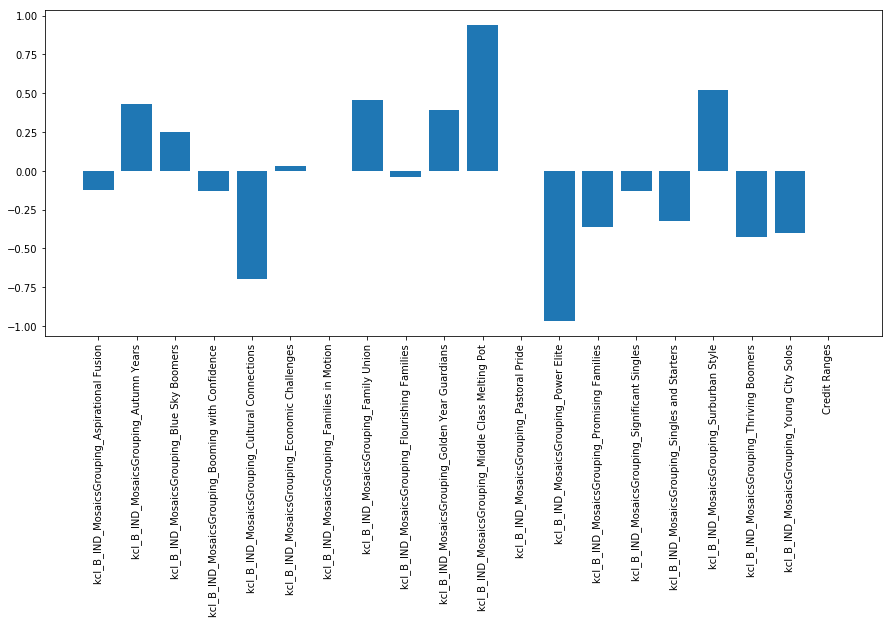

In [128]:
plt.figure(figsize = (15,6))
plt.bar(coef_df['feature'], coef_df['coefs'])
plt.xticks(rotation = 90)